In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, LayerNormalization, MultiHeadAttention, Dropout, GlobalAveragePooling1D
from sklearn.metrics import mean_squared_error
import math
import matplotlib.pyplot as plt
import yfinance as yf

In [2]:
df = yf.download('AAPL', start='2010-01-01', end='2023-10-01')

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


In [3]:
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - time_step - 1):
        a = dataset[i:(i + time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

In [4]:
# # Load and prepare the dataset
# file_path = 'TSLA.csv'  # Make sure to have your dataset ready
# df = pd.read_csv(file_path)
data = df[['Close']].values
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data)

# Parameters
time_step = 100
training_size = int(len(data_scaled) * 0.67)
test_size = len(data_scaled) - training_size 
train_data, test_data = data_scaled[0:training_size,:], data_scaled[training_size:len(data_scaled),:]

X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)


In [5]:
X_train.shape

(2216, 100)

In [6]:
# Reshape input for the model
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [7]:
X_train.shape

(2216, 100, 1)

In [6]:
# Transformer Block
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    x = LayerNormalization(epsilon=1e-6)(inputs)
    x = MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(x, x)
    x = Dropout(dropout)(x)
    res = x + inputs

    x = LayerNormalization(epsilon=1e-6)(res)
    x = Dense(ff_dim, activation="relu")(x)
    x = Dropout(dropout)(x)
    x = Dense(inputs.shape[-1])(x)
    return x + res

# Model Definition
inputs = Input(shape=(X_train.shape[1], X_train.shape[2]))
x = transformer_encoder(inputs, head_size=256, num_heads=4, ff_dim=4, dropout=0.1)
x = GlobalAveragePooling1D(data_format='channels_first')(x)
x = Dropout(0.1)(x)
x = Dense(20, activation="relu")(x)
outputs = Dense(1, activation="linear")(x)

model = Model(inputs=inputs, outputs=outputs)
model.compile(optimizer="adam", loss="mean_squared_error")

# Model Summary
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 100, 1)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 100, 1)    │          2 │ input_layer[0][0] │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 100, 1)    │      7,169 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 100, 1)    │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 100, 1)    │          0 │ dropout_1[0][0],  │
│                     │                   │            │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 100, 1)    │          2 │ add[0][0]         │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 100, 4)    │          8 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 100, 4)    │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 100, 1)    │          5 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 100, 1)    │          0 │ dense_1[0][0],    │
│                     │                   │            │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 100)       │          0 │ add_1[0][0]       │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 100)       │          0 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 20)        │      2,020 │ dropout_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 1)         │         21 │ dense_2[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 9,227 (36.04 KB)

 Trainable params: 9,227 (36.04 KB)

 Non-trainable params: 0 (0.00 B)

In [7]:
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=64, verbose=1)

Epoch 1/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 5s 71ms/step - loss: 0.0020 - val_loss: 0.0066
Epoch 2/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - loss: 0.0011 - val_loss: 0.0074
Epoch 3/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - loss: 7.7810e-04 - val_loss: 0.0019
Epoch 4/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step - loss: 7.0032e-04 - val_loss: 0.0032
Epoch 5/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step - loss: 4.8748e-04 - val_loss: 0.0070
Epoch 6/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step - loss: 4.2250e-04 - val_loss: 0.0014
Epoch 7/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step - loss: 3.4331e-04 - val_loss: 0.0015
Epoch 8/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step - loss: 2.8254e-04 - val_loss: 0.0017
Epoch 9/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step - loss: 2.2460e-04 - val_loss: 0.0017
Epoch 10/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step - loss: 2.2292e-04 - val_loss: 0.0013
Epoch 11/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step - loss: 1.8098e-04 - val_loss: 0.0018
Epoch 12/50
35/35 ━━━━━━━━━

In [51]:
model.save('transformer_stock_model.keras')

70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Train RMSE: 4896.19210851499
Test RMSE: 24715.099607192955


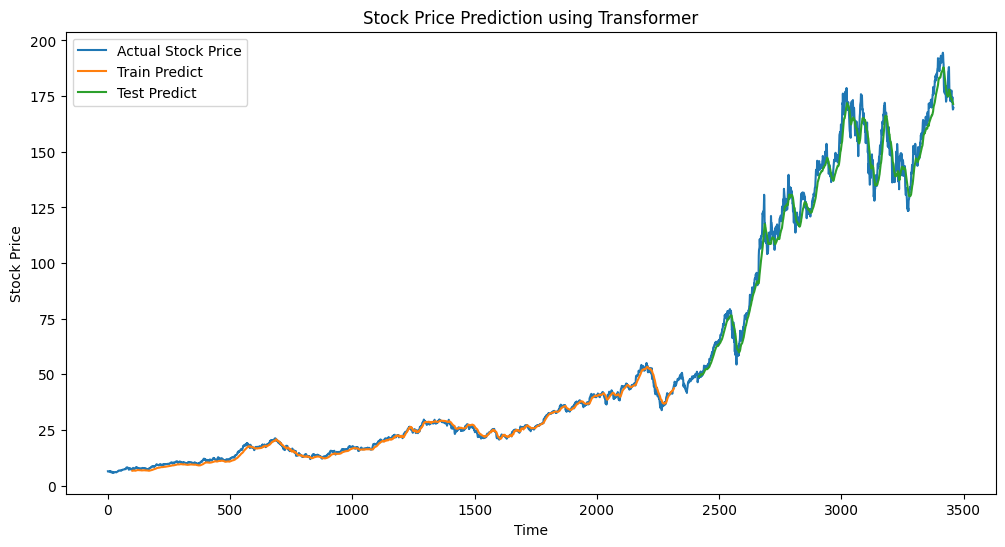

In [8]:
# Make predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Inverse transform predictions
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

# Evaluate the model (Optional: Calculate RMSE or other metrics)
train_rmse = math.sqrt(mean_squared_error(y_train, scaler.inverse_transform(train_predict.reshape(-1, 1))))
test_rmse = math.sqrt(mean_squared_error(y_test, scaler.inverse_transform(test_predict.reshape(-1, 1))))

print(f"Train RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")

# Plotting the results
# Adjust the time_step offset for plotting
trainPredictPlot = np.empty_like(data_scaled)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[time_step:len(train_predict)+time_step, :] = train_predict

# Shift test predictions for plotting
testPredictPlot = np.empty_like(data_scaled)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(time_step*2)+1:len(data_scaled)-1, :] = test_predict

# Plot baseline and predictions
plt.figure(figsize=(12, 6))
plt.plot(scaler.inverse_transform(data_scaled), label='Actual Stock Price')
plt.plot(trainPredictPlot, label='Train Predict')
plt.plot(testPredictPlot, label='Test Predict')
plt.title('Stock Price Prediction using Transformer')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

In [44]:
df_pred = yf.download('AAPL', start='2023-10-01', end='2025-03-01')

[*********************100%***********************]  1 of 1 completed


In [45]:
data_pred = df_pred[['Close']].values
data_pred_scaled = scaler.transform(data_pred)
X_pred, y_pred = create_dataset(data_pred_scaled, time_step)
X_pred = X_pred.reshape(X_pred.shape[0], X_pred.shape[1], 1)

In [25]:
X_pred.shape

(3, 100, 1)

In [46]:
future_preds = model.predict(X_pred)
# Inverse transform future predictions  
future_preds = scaler.inverse_transform(future_preds)

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


In [47]:
futurePredictPlot = np.empty_like(data_pred_scaled)
futurePredictPlot[:, :] = np.nan

In [33]:
futurePredictPlot.shape

(104, 1)

In [48]:
# Say you want to put the predictions at the end of the plot
start = len(data_pred_scaled) - len(future_preds)
futurePredictPlot[start:, :] = future_preds

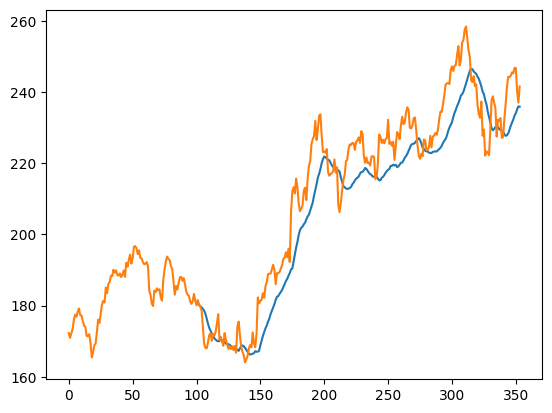

In [49]:
plt.plot(futurePredictPlot, label='Future Predictions')
plt.plot(data_pred, label='Actual Future Prices')